In [1]:
%%capture
from datasets import load_dataset

dataset = load_dataset("scaredmeow/shopee-reviews-tl-binary")


In [2]:
%%capture
import wandb

# initialize wandb
wandb.init(project="xlnet-finetuning", name="5th-run")

In [3]:
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
)

pretrained = "scaredmeow/xlnet-tagalog-base"
tokenizer = AutoTokenizer.from_pretrained(pretrained)


model = AutoModelForSequenceClassification.from_pretrained(pretrained, num_labels=2).to(
    "cuda"
)


In [4]:
def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        padding="max_length",
        truncation=True,
        max_length=512,
        return_tensors="pt",
    )


tokenized_datasets = dataset.map(tokenize_function, batched=True)


Loading cached processed dataset at C:\Users\Neilc\.cache\huggingface\datasets\scaredmeow___csv\scaredmeow--shopee-reviews-tl-binary-1d8ca6081d1e87c3\0.0.0\6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1\cache-2893d2e8bfd13996.arrow
Loading cached processed dataset at C:\Users\Neilc\.cache\huggingface\datasets\scaredmeow___csv\scaredmeow--shopee-reviews-tl-binary-1d8ca6081d1e87c3\0.0.0\6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1\cache-df42fbfc9c8ebdee.arrow
Loading cached processed dataset at C:\Users\Neilc\.cache\huggingface\datasets\scaredmeow___csv\scaredmeow--shopee-reviews-tl-binary-1d8ca6081d1e87c3\0.0.0\6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1\cache-5b185106621efb10.arrow


In [13]:
small_train_dataset = (
    tokenized_datasets["train"]
    .shuffle(seed=42)
    .select(range(int((len(tokenized_datasets["train"]) * 0.1))))
)
small_eval_dataset = (
    tokenized_datasets["test"]
    .shuffle(seed=42)
    .select(range(int((len(tokenized_datasets["test"]) * 0.1))))
)
small_test_dataset = (
    tokenized_datasets["validation"]
    .shuffle(seed=42)
    .select(range(int((len(tokenized_datasets["validation"]) * 0.1))))
)


Loading cached shuffled indices for dataset at C:\Users\Neilc\.cache\huggingface\datasets\scaredmeow___csv\scaredmeow--shopee-reviews-tl-binary-1d8ca6081d1e87c3\0.0.0\6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1\cache-c5464b19db367f15.arrow
Loading cached shuffled indices for dataset at C:\Users\Neilc\.cache\huggingface\datasets\scaredmeow___csv\scaredmeow--shopee-reviews-tl-binary-1d8ca6081d1e87c3\0.0.0\6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1\cache-e25a7f44079aac3c.arrow
Loading cached shuffled indices for dataset at C:\Users\Neilc\.cache\huggingface\datasets\scaredmeow___csv\scaredmeow--shopee-reviews-tl-binary-1d8ca6081d1e87c3\0.0.0\6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1\cache-cf509ac154b15c78.arrow


In [6]:
from transformers import TrainingArguments

training_args = TrainingArguments(output_dir="test_trainer")

import numpy as np
import evaluate

metric = evaluate.load("accuracy")


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)


from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="../models/finetuned-xlnet-shopee",
    evaluation_strategy="epoch",
        learning_rate=2e-5,
    do_train=True,
    do_eval=True,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    save_steps=1000,
    logging_steps=500,
    save_total_limit=2,
    num_train_epochs=3,
    seed=42,
    logging_dir="./logs",
    eval_steps=500,
    overwrite_output_dir=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    compute_metrics=compute_metrics,
)


In [7]:
trainer.train()


c:\Users\Neilc\dev\proj\nlp-thesis-xlnet-tagalog\.venv\lib\site-packages\transformers\optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/2100 [00:00<?, ?it/s]

{'loss': 0.5918, 'learning_rate': 3.809523809523809e-05, 'epoch': 0.71}


  0%|          | 0/150 [00:00<?, ?it/s]

{'eval_loss': 0.6087220311164856, 'eval_accuracy': 0.8266666666666667, 'eval_runtime': 80.13, 'eval_samples_per_second': 7.488, 'eval_steps_per_second': 1.872, 'epoch': 1.0}
{'loss': 0.5284, 'learning_rate': 2.6190476190476192e-05, 'epoch': 1.43}


  0%|          | 0/150 [00:00<?, ?it/s]

{'eval_loss': 0.2893364429473877, 'eval_accuracy': 0.9333333333333333, 'eval_runtime': 80.6621, 'eval_samples_per_second': 7.438, 'eval_steps_per_second': 1.86, 'epoch': 2.0}
{'loss': 0.4124, 'learning_rate': 1.4285714285714285e-05, 'epoch': 2.14}
{'loss': 0.2349, 'learning_rate': 2.3809523809523808e-06, 'epoch': 2.86}


  0%|          | 0/150 [00:00<?, ?it/s]

{'eval_loss': 0.3245619237422943, 'eval_accuracy': 0.93, 'eval_runtime': 81.0023, 'eval_samples_per_second': 7.407, 'eval_steps_per_second': 1.852, 'epoch': 3.0}
{'train_runtime': 2765.8198, 'train_samples_per_second': 3.037, 'train_steps_per_second': 0.759, 'train_loss': 0.4360509327479771, 'epoch': 3.0}


TrainOutput(global_step=2100, training_loss=0.4360509327479771, metrics={'train_runtime': 2765.8198, 'train_samples_per_second': 3.037, 'train_steps_per_second': 0.759, 'train_loss': 0.4360509327479771, 'epoch': 3.0})

In [8]:
trainer.save_model("../models/fine-tuned-roberta-1st-iter")
tokenizer.save_pretrained("../models/fine-tuned-roberta-1st-iter")


('../models/fine-tuned-roberta-1st-iter\\tokenizer_config.json',
 '../models/fine-tuned-roberta-1st-iter\\special_tokens_map.json',
 '../models/fine-tuned-roberta-1st-iter\\spiece.model',
 '../models/fine-tuned-roberta-1st-iter\\added_tokens.json',
 '../models/fine-tuned-roberta-1st-iter\\tokenizer.json')

In [9]:
dataset = tokenized_datasets["validation"]


In [14]:
pred = trainer.predict(small_test_dataset).predictions


  0%|          | 0/150 [00:00<?, ?it/s]

In [15]:
y_pred = np.argmax(pred, axis=1).tolist()
y_true = small_test_dataset["label"]


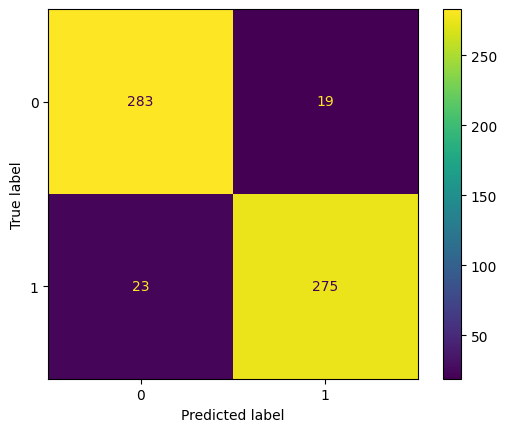

Accuracy: 0.93
Precision: 0.9301053754835268
Recall: 0.9299524423307702
F1 score: 0.9299875533428166


In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
)

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot()
plt.show()

# Compute the accuracy
acc = accuracy_score(y_true, y_pred)
print("Accuracy:", acc)

# Compute the precision
prec = precision_score(y_true, y_pred, average="macro")
print("Precision:", prec)

# Compute the recall
rec = recall_score(y_true, y_pred, average="macro")
print("Recall:", rec)

# Compute the f1 score
f1 = f1_score(y_true, y_pred, average="macro")
print("F1 score:", f1)

# # Compute the log-loss
# ll = log_loss(y_true, y_pred, labels=[0, 1, 2, 3, 4])
# print("Log-loss:", ll)

# # Compute the AUC-ROC
# auc = roc_auc_score(y_true, y_pred, average="macro", multi_class="ovr")
# print("AUC-ROC:", auc)
